In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
#%load_ext cudf.pandas
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from scipy.stats import skew

import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_slice,
    plot_parallel_coordinate
)

plt.style.use('seaborn-v0_8')
plt.rc('figure', figsize=(10,6), dpi=180)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=15, titlepad=10)
plt.rc('animation', html='html5')
plt.tight_layout()

%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e10/sample_submission.csv
/kaggle/input/playground-series-s5e10/train.csv
/kaggle/input/playground-series-s5e10/test.csv


<Figure size 1800x1080 with 0 Axes>

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e10/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv', index_col='id')

In [3]:
train.dtypes

road_type                  object
num_lanes                   int64
curvature                 float64
speed_limit                 int64
lighting                   object
weather                    object
road_signs_present           bool
public_road                  bool
time_of_day                object
holiday                      bool
school_season                bool
num_reported_accidents      int64
accident_risk             float64
dtype: object

# Assigned

In [4]:
num_cols = test.select_dtypes(include='float').columns.to_list()
cat_cols = test.select_dtypes(include='object').columns.to_list()

In [5]:
num_transform = StandardScaler()
cat_transform = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer([
    ('num', num_transform, num_cols),
    ('cat', cat_transform, cat_cols),
])

## Splitting the data into training and testing sets
- Use log transformation on the target variable

In [6]:
X = train.copy()
y = X.pop('accident_risk')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=2)

In [7]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'alpha': trial.suggest_float('alpha', 1e-2, 1, log=True),
        'lambda': trial.suggest_float('lambda', 1e-3, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10, log=True),
    }
    
    xgb = XGBRegressor(**params,
    random_state=2,
    n_jobs=-1,
    verbosity=0,
    objective='reg:squarederror'
    )
    
    pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', xgb)
    ])

    cv = KFold(n_splits=5, shuffle=True, random_state=2)
    score = -1 * cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    return score.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15, show_progress_bar=True)

[I 2025-10-24 07:22:23,490] A new study created in memory with name: no-name-a7784948-eeb2-4bc3-bf8d-0ffaba9d8ba4


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-10-24 07:23:21,068] Trial 0 finished with value: 0.011493940564550087 and parameters: {'n_estimators': 929, 'learning_rate': 0.006362721074910642, 'max_depth': 5, 'alpha': 0.19989237248197592, 'lambda': 0.3215013408514583, 'subsample': 0.8741116733803639, 'colsample_bytree': 0.9171898039644689, 'min_child_weight': 6}. Best is trial 0 with value: 0.011493940564550087.
[I 2025-10-24 07:23:59,875] Trial 1 finished with value: 0.012631440783976586 and parameters: {'n_estimators': 676, 'learning_rate': 0.003084101259218187, 'max_depth': 4, 'alpha': 0.5433876275218161, 'lambda': 0.08353335442385042, 'subsample': 0.6297652122916275, 'colsample_bytree': 0.6418427876486834, 'min_child_weight': 7}. Best is trial 0 with value: 0.011493940564550087.
[I 2025-10-24 07:25:05,811] Trial 2 finished with value: 0.01159535233458514 and parameters: {'n_estimators': 730, 'learning_rate': 0.12085253474843678, 'max_depth': 9, 'alpha': 0.11652290919301625, 'lambda': 0.6626129610814001, 'subsample': 0.

In [8]:
# Optimization history (how loss improved over trials)
plot_optimization_history(study)

In [9]:
# Parameter value vs. score relationship
plot_slice(study)

In [10]:
# Parameter importance plot (which hyperparameters matter most)
plot_param_importances(study)

In [11]:
best_params = study.best_params

best_model = XGBRegressor(
    **best_params,
    random_state=2,
    n_jobs=-1,
    objective='reg:squarederror'
)

final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', best_model)
])

final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['curvature']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['road_type', 'lighting',
                                                   'weather',
                                                   'time_of_day'])])),
                ('xgb',
                 XGBRegressor(alpha=0.9943561230592424, base_score=None,
                              booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              lambda=9.445246456589194,
                              learning_rate=0.03905042886553163, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=7, max_leaves=None,
                              min_child_weight=3, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=360, n_jobs=-1, ...))])

In [12]:
yhat = final_pipeline.predict(X_valid)

In [13]:
mae = mean_absolute_error(y_valid, yhat)
mse = mean_squared_error(y_valid, yhat)
rmse = np.sqrt(mean_squared_error(y_valid, yhat))
r2score = r2_score(y_valid, yhat)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2score:.4f}")

Mean Absolute Error (MAE): 0.0897
Mean Squared Error (MSE): 0.0114
Root Mean Squared Error (RMSE): 0.1069
R² Score: 0.5882


### Plot Actual vs Predicted values

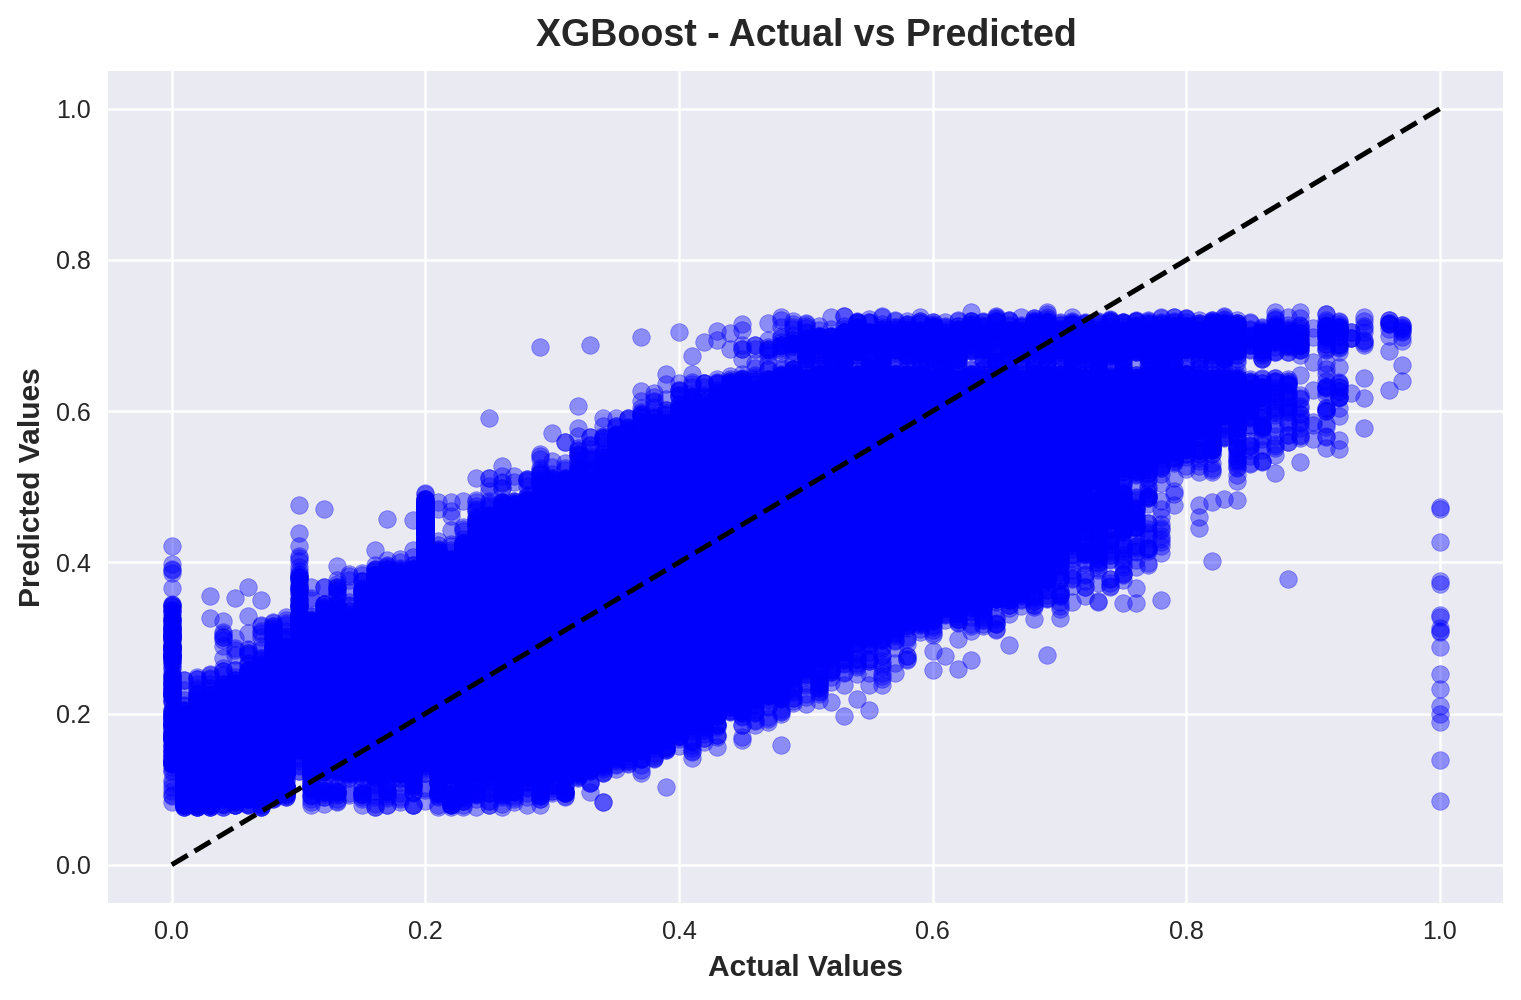

In [14]:
plt.scatter(y_valid, yhat, alpha=0.4, color='blue')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("XGBoost - Actual vs Predicted")
plt.show()

In [15]:
X_test = test.copy()
test_preds = final_pipeline.predict(X_test)

In [16]:
sub = pd.read_csv('/kaggle/input/playground-series-s5e10/sample_submission.csv')
sub['accident_risk'] = test_preds
sub.to_csv('submission.csv', index=False)
sub.head()

,id,accident_risk
0,517754,0.358009
1,517755,0.202317
2,517756,0.299579
3,517757,0.423859
4,517758,0.353524
